
# Bootstrapping and Bagging for Regression with Bias-Variance Analysis

This notebook demonstrates how bootstrapping is used in Bagging for regression problems.
We illustrate the impact on bias and variance using repeated simulations and plot the results.

The analysis is based on the decomposition of the mean squared error:

$$
\mathbb{E}[(\hat{f}(x) - f(x))^2] = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}
$$


The code below estimates the **bias²** and **variance** components of the prediction error for a regression model, based on repeated predictions from multiple training datasets (e.g. via bootstrapping).

---

### 📌 Context

In regression, the expected prediction error for a point $x$ can be decomposed as:

$$
\mathbb{E}[(\hat{f}(x) - f(x))^2] = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}
$$

This code approximates this decomposition empirically by:

* Generating multiple model predictions for the same test set (from different training samples)
* Comparing these predictions to the true function values $f(x)$

---

### 🔍 Code Breakdown

```python
def bias_variance_analysis(predictions, f_true):
```

* **`predictions`**: a 2D NumPy array of shape `(n_trials, n_points)`, where each row corresponds to predictions made by a model trained on one bootstrap sample.
* **`f_true`**: the ground truth values of the function being approximated, for the same test points.

---

#### Step 1: Mean prediction across all trials

```python
avg_pred = np.mean(predictions, axis=0)
```

* Computes the **average predicted value** at each test point across all trials.
* This is used to estimate the **systematic component** of the model’s output.

---

#### Step 2: Estimate Bias²

```python
bias2 = np.mean((avg_pred - f_true) ** 2)
```

* For each test point, compute the squared difference between the average prediction and the true value.
* Take the average over all test points.

This is the empirical estimate of **bias squared**:

$$
\text{Bias}^2 \approx \frac{1}{n} \sum_{i=1}^n \left( \mathbb{E}[\hat{f}(x_i)] - f(x_i) \right)^2
$$

---

#### Step 3: Estimate Variance

```python
variance = np.mean(np.var(predictions, axis=0))
```

* For each test point, compute the variance of predictions across all trials.
* Then average across all test points.

This gives:

$$
\text{Variance} \approx \frac{1}{n} \sum_{i=1}^n \text{Var}[\hat{f}(x_i)]
$$

---

#### Step 4: Return values

```python
return bias2, variance
```

* Returns the **mean bias squared** and **mean variance** over the test set.

---

### 🧠 Intuition

* If `bias2` is high: The model underfits and fails to capture the structure of the true function.
* If `variance` is high: The model overfits and is sensitive to training data variations.
* Bagging aims to **reduce variance** without increasing bias too much.

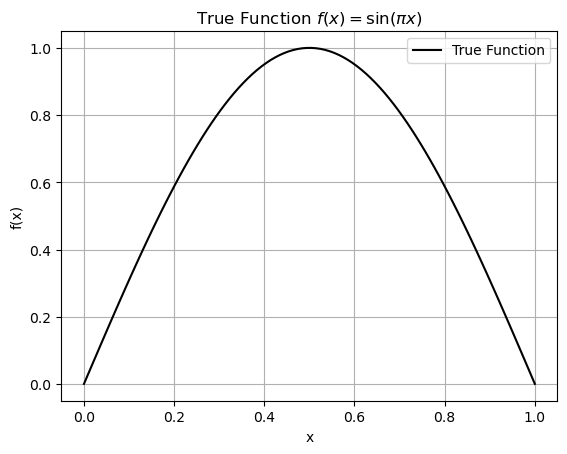

In [14]:

import numpy as np
import matplotlib.pyplot as plt

# True function
def f(x):
    return np.sin(np.pi * x)

# Generate data
def generate_data(n_samples=30, noise_std=0.3):
    X = np.random.rand(n_samples)
    y = f(X) + np.random.normal(0, noise_std, size=n_samples)
    return X.reshape(-1, 1), y

# Plot the true function
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
plt.plot(x_plot, f(x_plot), label='True Function', color='black')
plt.title(r"True Function $f(x) = \sin(\pi x)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


In [15]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

n_trials = 100
n_samples = 30
noise_std = 0.3
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
f_true = f(x_test)

# Store predictions
predictions_dt = []
predictions_bag = []

for _ in range(n_trials):
    X_train, y_train = generate_data(n_samples, noise_std)
    
    # Decision Tree
    dt = DecisionTreeRegressor(max_depth=3)
    dt.fit(X_train, y_train)
    predictions_dt.append(dt.predict(x_test))
    
    # Bagging
    bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                           n_estimators=10, bootstrap=True)
    bag.fit(X_train, y_train)
    predictions_bag.append(bag.predict(x_test))

# Convert to arrays
predictions_dt = np.array(predictions_dt)
predictions_bag = np.array(predictions_bag)

# Compute bias and variance
def bias_variance_analysis(predictions, f_true):
    avg_pred = np.mean(predictions, axis=0)
    bias2 = np.mean((avg_pred - f_true) ** 2)
    variance = np.mean(np.var(predictions, axis=0))
    return bias2, variance

bias2_dt, var_dt = bias_variance_analysis(predictions_dt, f_true)
bias2_bag, var_bag = bias_variance_analysis(predictions_bag, f_true)

print("Decision Tree - Bias^2: %.4f, Variance: %.4f" % (bias2_dt, var_dt))
print("Bagging        - Bias^2: %.4f, Variance: %.4f" % (bias2_bag, var_bag))


Decision Tree - Bias^2: 0.1833, Variance: 0.0487
Bagging        - Bias^2: 0.1737, Variance: 0.0302


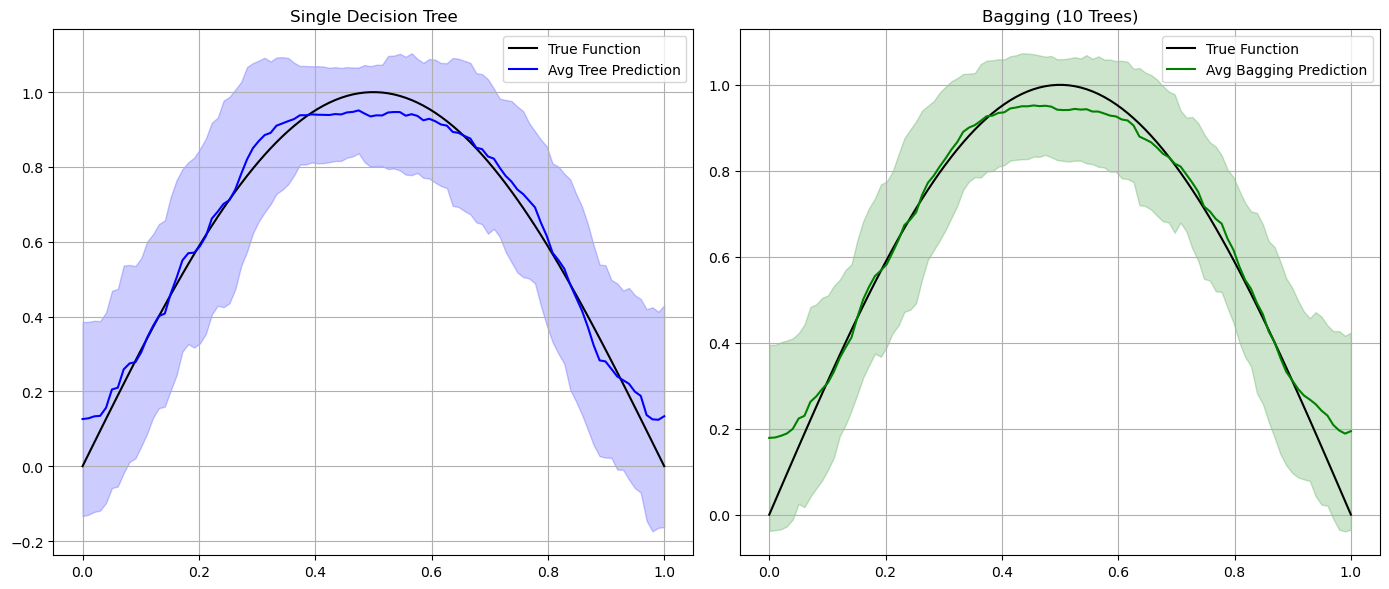

In [16]:

plt.figure(figsize=(14, 6))

# Plot average predictions
plt.subplot(1, 2, 1)
plt.plot(x_test, f_true, label="True Function", color="black")
plt.plot(x_test, predictions_dt.mean(axis=0), label="Avg Tree Prediction", color="blue")
plt.fill_between(x_test.flatten(),
                 predictions_dt.mean(axis=0) - predictions_dt.std(axis=0),
                 predictions_dt.mean(axis=0) + predictions_dt.std(axis=0),
                 color="blue", alpha=0.2)
plt.title("Single Decision Tree")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_test, f_true, label="True Function", color="black")
plt.plot(x_test, predictions_bag.mean(axis=0), label="Avg Bagging Prediction", color="green")
plt.fill_between(x_test.flatten(),
                 predictions_bag.mean(axis=0) - predictions_bag.std(axis=0),
                 predictions_bag.mean(axis=0) + predictions_bag.std(axis=0),
                 color="green", alpha=0.2)
plt.title("Bagging (10 Trees)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## Irreducible Error and Learning Curve Analysis

In this section, we estimate the irreducible error by computing the total MSE and subtracting the bias² and variance.

We also analyze how the bias and variance evolve as the training size increases (learning curves).


In [17]:

from sklearn.metrics import mean_squared_error

# Estimate irreducible error
def estimate_irreducible_error(predictions, f_true, noise_std):
    total_error = np.mean((predictions - f_true) ** 2)
    return total_error - np.mean((np.mean(predictions, axis=0) - f_true) ** 2) - np.mean(np.var(predictions, axis=0))

irreducible_dt = estimate_irreducible_error(predictions_dt, f_true, noise_std)
irreducible_bag = estimate_irreducible_error(predictions_bag, f_true, noise_std)

print("Estimated Irreducible Error (Decision Tree): %.4f" % irreducible_dt)
print("Estimated Irreducible Error (Bagging): %.4f" % irreducible_bag)

# Learning curves
sample_sizes = [10, 20, 50, 100, 200]
bias2_dt_list, var_dt_list, mse_dt_list = [], [], []
bias2_bag_list, var_bag_list, mse_bag_list = [], [], []

for n in sample_sizes:
    preds_dt, preds_bag = [], []
    for _ in range(n_trials):
        X_train, y_train = generate_data(n, noise_std)
        dt = DecisionTreeRegressor(max_depth=3)
        dt.fit(X_train, y_train)
        preds_dt.append(dt.predict(x_test))

        bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                               n_estimators=10, bootstrap=True)
        bag.fit(X_train, y_train)
        preds_bag.append(bag.predict(x_test))

    preds_dt = np.array(preds_dt)
    preds_bag = np.array(preds_bag)

    avg_dt = np.mean(preds_dt, axis=0)
    avg_bag = np.mean(preds_bag, axis=0)

    bias2_dt_list.append(np.mean((avg_dt - f_true) ** 2))
    var_dt_list.append(np.mean(np.var(preds_dt, axis=0)))
    mse_dt_list.append(mean_squared_error(f_true, avg_dt))

    bias2_bag_list.append(np.mean((avg_bag - f_true) ** 2))
    var_bag_list.append(np.mean(np.var(preds_bag, axis=0)))
    mse_bag_list.append(mean_squared_error(f_true, avg_bag))


Estimated Irreducible Error (Decision Tree): 0.0019
Estimated Irreducible Error (Bagging): -0.0025


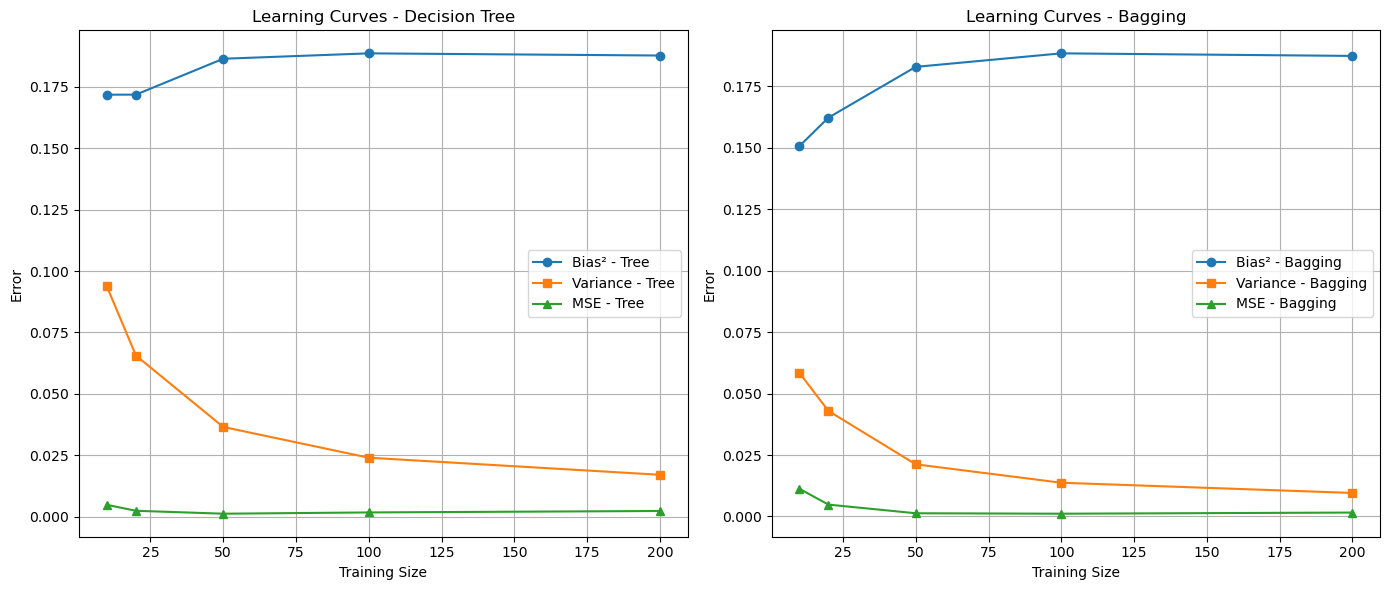

In [18]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(sample_sizes, bias2_dt_list, label="Bias² - Tree", marker='o')
plt.plot(sample_sizes, var_dt_list, label="Variance - Tree", marker='s')
plt.plot(sample_sizes, mse_dt_list, label="MSE - Tree", marker='^')
plt.title("Learning Curves - Decision Tree")
plt.xlabel("Training Size")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sample_sizes, bias2_bag_list, label="Bias² - Bagging", marker='o')
plt.plot(sample_sizes, var_bag_list, label="Variance - Bagging", marker='s')
plt.plot(sample_sizes, mse_bag_list, label="MSE - Bagging", marker='^')
plt.title("Learning Curves - Bagging")
plt.xlabel("Training Size")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
